In [4]:
!pip install hydra-core --upgrade -qq
# exit(0)

In [3]:
!pip install lightly -qq

In [6]:
# !pip install omegaconf

In [6]:
# os.listdir("./")
import os
os.cpu_count()

2

## THE START....
---  --- 

In [42]:
"""

**** REFERENCES RESOURCES: *********


https://theaisummer.com/simclr/

https://github.com/sadimanna/simclr_pytorch/blob/main/SImCLR_cifar10.ipynb

https://towardsdatascience.com/train-without-labeling-data-using-self-supervised-learning-by-relational-reasoning-b0298ad818f9



"""
print("Updated Reference Resources")

Updated Reference Resources


In [5]:
# # !pip install pytorch-lightning

# !pip install git+https://github.com/PyTorchLightning/pytorch-lightning
# import pytorch_lightning as pl
# print(pl.__version__)
# # exit(0)

In [6]:

# import libraries to be used
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm



# torch modules for dealing with model and images
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F

# torch lighting to be used for training
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

%matplotlib inline


In [7]:
# tensorboard
%load_ext tensorboard


In [8]:

# model to be saved path
CHECKPOINT_PATH = "./"


NUM_WORKERS = 2
NUM_WORKERS

2

In [9]:
pl.seed_everything(0)

device = torch.device("cuda:0")


In [10]:
# set all activities on gpu
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Data Augumentation

In [11]:
class contrastTransformation(object):
    """
    A single image prediction output will be evaluated, In this case, a single image batch will need to have tow samples so that their results can be compaired.
    i.e preparing the data loading  to have  two different, random augmentations for each single image in the batch. 
    This will be done by this transfomer class which normally is caled contrast transfomation

    """
    def __init__(self, general_transforms, sample_img_views=2):
        self.general_transforms = general_transforms
        self.sample_img_views = sample_img_views

    def __call__(self, x):
        #transfom the images
        return [self.general_transforms(x) for i in range(self.sample_img_views)]

In [12]:
"""
Create Some Transformations rto be used

THe direction was that we apply the following:
    1. Color Distortion
    2. Cropping and Resizing to original Shape In this case 32by 32 as incase of cifar10
    3. Random Gausina Blur
"""



def get_transfomations():
    trans_items =[
        transforms.RandomApply([transforms.ColorJitter(brightness=0.51,contrast=0.35,saturation=0.55,hue=0.091)], p=0.75), #Colow Distorition 
        transforms.RandomResizedCrop(size=32),#Cropping and Resizing size to be 32 by 32
        transforms.GaussianBlur(kernel_size=5), #Gausian Blurring
        transforms.ToTensor(),#convert to tensor
        transforms.Normalize((0.5,), (0.5,)) #normalize the pixels
    ]
    return transforms.Compose(trans_items)



# get all transformation to be used
transforms_ftns = get_transfomations()

transforms_ftns

Compose(
    RandomApply(
    p=0.75
    ColorJitter(brightness=[0.49, 1.51], contrast=[0.65, 1.35], saturation=[0.44999999999999996, 1.55], hue=[-0.091, 0.091])
)
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [13]:
# each image will have 2 samples
cifar10_data = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True,
    transform=contrastTransformation(get_transfomations(), 
                                         sample_img_views=2))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10


In [14]:
# train data 
cifar10_data_val = torchvision.datasets.CIFAR10(
    "datasets/cifar10", train=False, download=True,  
    transform=contrastTransformation(get_transfomations(), 
                                         sample_img_views=2))

Files already downloaded and verified


In [15]:
len(cifar10_data), len(cifar10_data_val)

(50000, 10000)

### View Sample Images

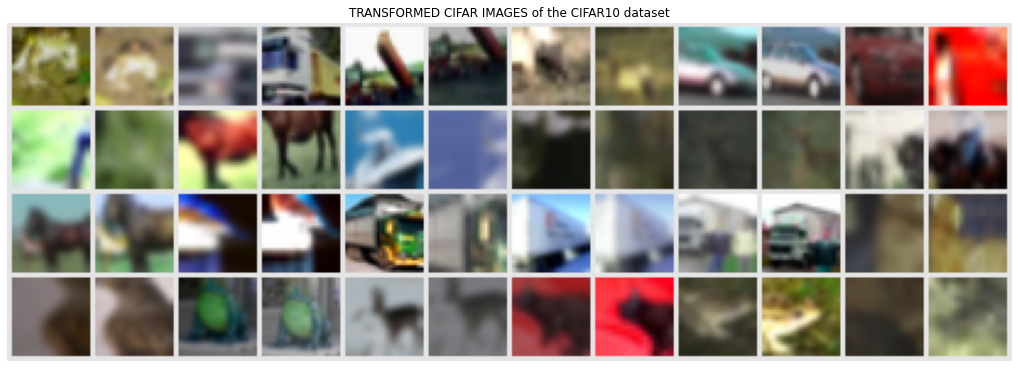

In [16]:
# Visualize some examples

plt.figure(figsize=(18,10))
plt.title('TRANSFORMED CIFAR IMAGES of the CIFAR10 dataset')
plt.imshow(
    torchvision.utils.make_grid(torch.stack([img for idx in range(24) for img in cifar10_data[idx][0]], dim=0), nrow=12, normalize=True, pad_value=0.9).permute(1, 2, 0)
)
plt.axis('off')
plt.show()
plt.close()

In [17]:
"""
In each image, the images are slightly different because of the transformation that they have undergone.
Each Image has its partner. The model needs to match the two images 
"""

'\nIn each image, the images are slightly different because of the transformation that they have undergone.\nEach Image has its partner. The model needs to match the two images \n'

### SIMCR MODEL Definition

In [18]:
# some params definition
MODEL_TEMP = 0.05
EPOCHS = 4
WEIGHT_DECAY = 1e3
LEARNING_RATE= 3e3
HIDDEN_DIM = 128

In [19]:




class SimCLR(pl.LightningModule):

    def __init__(self,  hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
    
        #load the model without pretrained weights
        self.resnet18 = torchvision.models.resnet18(
            pretrained=False,num_classes=2*hidden_dim
            )
        #add mlp layers to the resnet model
        self.resnet18.fc = nn.Sequential(
            self.resnet18.fc,  
            nn.ReLU(inplace=True),
            nn.Linear(2*hidden_dim, hidden_dim)
        )


    def configure_optimizers(self):

        optimizer = [torch.optim.AdamW(self.parameters(),lr=self.hparams.lr,weight_decay=self.hparams.weight_decay)]
        lr_scheduler = [torch.optim.lr_scheduler.CosineAnnealingLR(optimizer[0],T_max=self.hparams.max_epochs,eta_min=self.hparams.lr/50)]
        return optimizer, lr_scheduler

    def inference_model_loss_information(self, img_batch, train=True):

        """Only Images are used and their Labels are being Ignored"""
        curr_imgs, _ = img_batch
        curr_imgs = torch.cat(curr_imgs, dim=0)

        """Pass the Images through the Network for self Training"""
        preds_features = self.resnet18(curr_imgs)

        """The model results Will be compaired How similar their Are i,e If the model is able to distinguish two similar Images"""
        cos_similarity_res = torch.nn.functional.cosine_similarity(preds_features[:,None,:], preds_features[None,:,:], dim=-1)
        #create a mask of the similarity
        self_mask = torch.eye(cos_similarity_res.shape[0], dtype=torch.bool, device=cos_similarity_res.device)
        # Fill hte sim with the masks
        cos_similarity_res.masked_fill_(self_mask, -9e15)

        #find positive results from the batch images i,e we have two images instances for each
        positive_mask = self_mask.roll(shifts=cos_similarity_res.shape[0]//2, dims=0)
    
        #get nce loss
        cos_similarity_res = cos_similarity_res /self.hparams.temperature
        nce_loss = -cos_similarity_res[positive_mask] + torch.logsumexp(cos_similarity_res, dim=-1)
        nce_loss = nce_loss.mean()

        # Logging loss
        if train:
            mode = 'training'
            self.log(mode+'_loss', nce_loss)
            total_loss.append(nce_loss)
        else:
            mode ='validating'
            self.log(mode+'_loss', nce_loss)
            val_total_loss.append(nce_loss)
        
        #rank the postive res
        comb_sim = torch.cat([cos_similarity_res[positive_mask][:,None],cos_similarity_res.masked_fill(positive_mask, -9e15)],dim=-1)
        similarity_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        #log the metric results
        self.log(mode+'_acc_top_1', (similarity_argsort == 0).float().mean())
        self.log(mode+'_acc_top_5', (similarity_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+similarity_argsort.float().mean())

        #add these metrucs to a liss for further visualization
        if train:
            top_1_acc.append((similarity_argsort == 0).float().mean())
            top_5_acc.append((similarity_argsort < 5).float().mean())
        else:
            val_top_1_acc.append((similarity_argsort == 0).float().mean())
            val_top_5_acc.append((similarity_argsort < 5).float().mean())
        return nce_loss

    def training_step(self, batch, batch_idx):
        """Training step"""
        return self.inference_model_loss_information(batch)

    def validation_step(self, batch, batch_idx):
        """Validation stem"""
        self.inference_model_loss_information(batch, False)


In [20]:
def train_simclr(batch_size, max_epochs=250, **kwargs):
    """
    This Function Trains the SIMCLR model usingtorch lightting
    """

    #set model params
    simclr_trainer = pl.Trainer(default_root_dir='./SimCLR',gpus=1 if str(device)=='cuda:0' else 0,
                                max_epochs=max_epochs,
                                callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='validating_acc_top_5'),
                                           LearningRateMonitor('epoch')])
    #stop model default logging

    simclr_trainer.logger._default_hp_metric = None

    #IF the model is saved already, load it else continue training and validation
    pretrained_model_checkpoint = os.path.join("./", 'SimCLR.ckpt')
    if os.path.isfile(pretrained_model_checkpoint):
        print(f'Loading Model Already Saved In  {pretrained_model_checkpoint} ......')
        #load the model with its states dict
        model = SimCLR.load_from_checkpoint(pretrained_model_checkpoint)
    else:
        training_data_loader = data.DataLoader(cifar10_data, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True, pin_memory=True)
        val_data_loader = data.DataLoader(cifar10_data_val, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True, pin_memory=True)
        #setting seed to get similar results always
        pl.seed_everything(2022)
        #initialize the model and train it
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        simclr_trainer.fit(model, training_data_loader, val_data_loader)
        #get the best model
        model = SimCLR.load_from_checkpoint(simclr_trainer.checkpoint_callback.best_model_path)

    return model



In [21]:
!rm -r ./SimCLR

rm: cannot remove './SimCLR': No such file or directory


In [22]:

total_loss =[]
top_1_acc =[]
top_5_acc =[]


val_total_loss =[]
val_top_1_acc =[]
val_top_5_acc =[]


MODEL_TEMP = 0.075
EPOCHS = 2
WEIGHT_DECAY = 1e4
LEARNING_RATE= 5e-4
HIDDEN_DIM = 128
BATCH_SIZE=256
simclr_model = train_simclr(batch_size=256,hidden_dim=1287,weight_decay=1e-4,max_epochs=2,lr=5e-4,temperature=0.0)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [23]:
%tensorboard --logdir ./SimCLR/

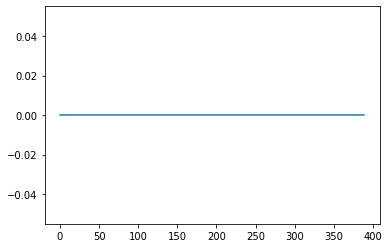

In [24]:
plt.plot([x.detach().item()  for x in top_1_acc])

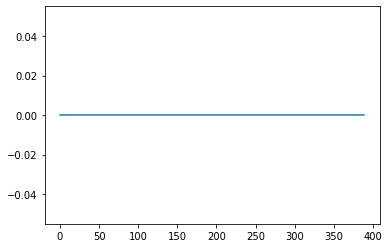

In [25]:
plt.plot([x.detach().item()  for x in top_5_acc])

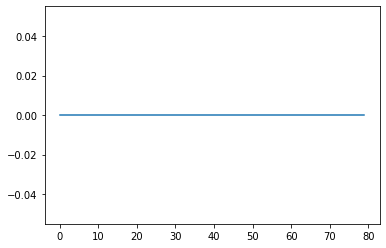

In [26]:
plt.plot([x.detach().item()  for x in val_top_5_acc])

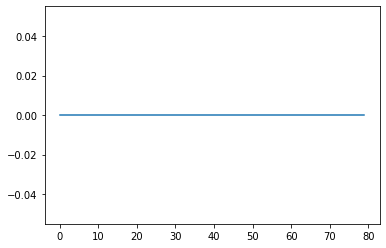

In [27]:
plt.plot([x.detach().item()  for x in val_top_1_acc])

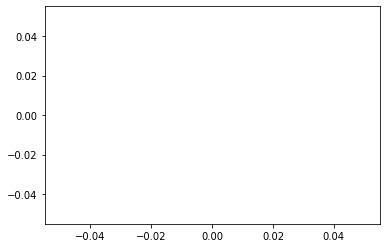

In [28]:
plt.plot([x.detach().item()  for x in total_loss])

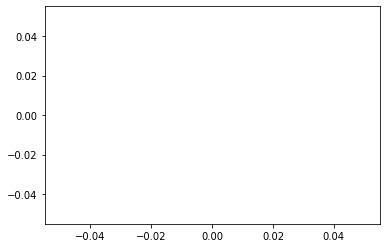

In [29]:
plt.plot([x.detach().item()  for x in val_total_loss])

### FINE TUNING AND TRAINING FOR CIFAR100 dataset.


- The model Trained above will be used.
- PyTorch lightning module class will be used to encapsulate the logic (INHERITED as above). 
- The pretrained resnet18 backbone on cifar10 will be used here for downstream task, without its projection head. A single linear layer will be added at the head on top to act as a classfier.

In [30]:
# These lists will hold the accuracies
train_acc =[]
train_loss =[]

val_acc =[]
val_loss =[]


loss_fn = nn.CrossEntropyLoss()

class DownStream_Model(pl.LightningModule):

    def __init__(self, img_features, n_classes, lr, weight_decay, max_epochs=5):
        super().__init__()
        self.save_hyperparameters()

        #this is the layer to be added on top as a classifier of n classes
        self.model = nn.Linear(img_features, n_classes)

        self.optimizer = optim.SGD(self.parameters(),lr=self.hparams.lr,weight_decay=self.hparams.weight_decay, momentum = 0.9)

        self.scheduler =  optim.lr_scheduler.MultiStepLR(self.optimizer,milestones=[int(self.hparams.max_epochs*0.65),int(self.hparams.max_epochs*0.8)],gamma=0.85)
    def configure_optimizers(self):
        """Optimized params tuned"""
        return [self.optimizer], [self.scheduler]

    def pass_through_network(self, batch, train=True):
        """
        PASS INPUTS THROUGH THE NETWORK
        """
        img_feats, labels = batch
        preds = self.model(img_feats)

        #self.optimizer.zero_grad()
        # Get the loss
        loss = loss_fn(preds, labels)

        #loss.backward()
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        #self.optimizer.step()


        if train == "False1":
            mode = "test"
            val_loss.append(loss)
            val_acc.append(acc)            
        if train:
            mode ='train'
            val_loss.append(loss)
            val_acc.append(acc)
        else:
            mode ='val'
            val_loss.append(loss)
            val_acc.append(acc)

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.pass_through_network(batch, True)

    def validation_step(self, batch, batch_idx):
        self.pass_through_network(batch,False)

    def test_step(self, batch, batch_idx):
        self.pass_through_network(batch, "False1")

In [31]:
"""
Images will only be converted to tensors and normalized its pixels
"""
transforms_ftn = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
cifar100_train_img_data = torchvision.datasets.CIFAR100(root="datasets/cifar100", train=True, download=True,transform=transforms_ftn)
cifar_100_test_img_data = torchvision.datasets.CIFAR100(root="datasets/cifar100", train=False, download=True,transform=transforms_ftn)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting datasets/cifar100/cifar-100-python.tar.gz to datasets/cifar100
Files already downloaded and verified


In [32]:
# check size
print("Number of training examples:", len(cifar100_train_img_data))
print("Number of test examples:", len(cifar_100_test_img_data))

Number of training examples: 50000
Number of test examples: 10000


In [33]:

from copy import deepcopy
@torch.no_grad()
def create_data_features(model, dataset):
    """
    Prepare some features
    """
    #get the base without the head
    backbone_model = deepcopy(model.resnet18)
    # add head
    backbone_model.fc = nn.Identity()
    backbone_model.eval()
    backbone_model.to(device)
    img_feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)):
        batch_imgs = batch_imgs.to(device)
        batch_feats = backbone_model(batch_imgs)
        img_feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    img_feats = torch.cat(img_feats, dim=0)
    labels = torch.cat(labels, dim=0)
    labels, idxs = labels.sort()
    img_feats = img_feats[idxs]
    return data.TensorDataset(img_feats, labels)

In [34]:
cifar100_train_feats_simclr = create_data_features(simclr_model, cifar100_train_img_data)
cifar100_test_feats_simclr = create_data_features(simclr_model, cifar_100_test_img_data)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [35]:

# create a trainer for cifar100

def Trainer_cifar100(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=10, **kwargs):
    cifar100_trainer = pl.Trainer(default_root_dir="./Cifar100",gpus=1 if str(device)=="cuda:0" else 0,max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    #don;t show logs
    cifar100_trainer.logger._default_hp_metric = None
    #create data loaders
    train_loader = data.DataLoader(cifar100_train_feats_simclr, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(cifar100_test_feats_simclr, batch_size=batch_size, shuffle=False)
    
    #train
    saved_filename = os.path.join(CHECKPOINT_PATH, f"DownStream{model_suffix}.ckpt")
    if os.path.isfile(saved_filename):
        print(f" Downstream Model Saved is being Loaded from {saved_filename}")
        model = DownStream_Model.load_from_checkpoint(saved_filename)
    else:
        pl.seed_everything(2022)
        model = DownStream_Model(**kwargs)
        cifar100_trainer.fit(model, train_loader, test_loader)
        model = DownStream_Model.load_from_checkpoint(cifar100_trainer.checkpoint_callback.best_model_path)

        #test the model
    train_result = cifar100_trainer.test(model, train_loader, verbose=False)
    test_result = cifar100_trainer.test(model, test_loader, verbose=False)
    return model, {"train_res":train_result, "test_res":test_result}

In [36]:
def split_smaller_version(img_data, size_per_label):
    return  data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:size_per_label].flatten(0, 1) for t in img_data.tensors]
    )

In [38]:
results = {}
for size_lbl in [5, 10]:
    sub_train_set = split_smaller_version(cifar100_test_feats_simclr, size_lbl)
    _, curr_res = Trainer_cifar100(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=cifar100_test_feats_simclr,
                                        model_suffix=size_lbl,
                                        img_features=cifar100_train_feats_simclr.tensors[0].shape[1],
                                        n_classes=100,
                                        lr=2e-3,
                                        weight_decay=1e-3)
    results[size_lbl] = curr_res

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

In [39]:
results

{5: {'train_res': [{'train_loss': nan, 'train_acc': 0.009999999776482582}],
  'test_res': [{'train_loss': nan, 'train_acc': 0.009999999776482582}]},
 10: {'train_res': [{'train_loss': nan, 'train_acc': 0.009999999776482582}],
  'test_res': [{'train_loss': nan, 'train_acc': 0.009999999776482582}]}}